<a href="https://colab.research.google.com/github/jackc03/SCREEn/blob/main/SCREEn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRNN-Assisted Video Upscaling ASIC  
### A Hardware/Software Codesign Walk-Through

Welcome! This notebook is the companion journal for my **hardware/software co-design project**: an **ASIC accelerator that upgrades 720 p video streams to 1080 p in real time** using a **Convolutional Recurrent Neural Network (CRNN)**.  
The goal is to show—step by step—how machine-learning research, algorithm engineering, RTL design, and physical-design constraints converge into a single silicon-ready pipeline.

---

## Motivation & Problem Statement
- **Bandwidth bottleneck:** Mobile and embedded devices often downlink only 720 p to save bandwidth or storage.  
- **Quality gap:** Naïve spatial upscalers (bilinear/nearest) yield soft edges and ringing artifacts.  
- **Opportunity:** A compact CRNN can *learn* spatio-temporal correlations to hallucinate sharper textures, delivering near-native 1080 p quality at a fraction of the bitrate.  
- **Challenge:** Deep models are compute-hungry. Achieving **⩾ 30 fps at 1080 p** within a **< 2 W power envelope** and **2 mm² core area** (SKY130 180 MHz budget) demands *co-optimized* hardware and software.

---

## High-Level Architecture
| Stage | Function | Runs on |
|-------|----------|---------|
| **Pre-Upscale** | Bilinear 720 p → 1080 p (seed image) | On-chip DMA + line buffer |
| **CRNN Core** | 5-layer Conv + gated recurrent loops | **Custom ASIC macro** |
| **Post-Process** | Skip connection + tone mapping | **ASIC** |
| **Runtime Driver** | Frame-DMA orchestration, quantized inference kernel, metrics | **RISC-V firmware** |

A full RTL block diagram appears later in the notebook.

---

## Dataset & Training Recipe
- **Dataset:** [DAVIS-2017 Unsupervised, Train/Val, Full-Resolution]—only raw RGB frames.  
  *LR frames* are generated on the fly via bicubic ↓ in the `Dataset` class.  
- **Loss mix:** Charbonnier (pixel) + temporal warping + GAN adversarial (`PatchGAN`, spectral-norm D).  
- **Compression:** 4-bit weight quantization (PACT) + 8-bit activations, validated with < 0.2 dB PSNR drop.

A reusable PyTorch pipeline is provided to replicate every experiment.

---

## Notebook Roadmap
1. **Introduction** → this section!
2. **Dataset setup** → download & prepare DAVIS-2017 for training
3. **Model definition** → CRNN layers, quantization stubs  
4. **Training loop** → adversarial curriculum, PSNR logger  
5. **Hardware profiling** → MAC counts, SRAM fits, throughput model  
6. **RTL generation** → Verilog modules, clock gating, synthesis (OpenROAD-Sky130)  
7. **HW/SW integration** → RISC-V firmware, AXI-4 stream driver  
8. **Results & discussion** → quality metrics, power/timing closure, future work

---

<!-- ## 5. How to Run
```bash
git clone <this-repo>
cd notebook/
pip install -r requirements.txt -->


## 2 Dataset Generation & Processing

This section sets up everything we need to feed the **CRNN upscaler** with clean, memory-friendly training data.

### 2.1 Source Material – DAVIS-2017 (Unsupervised, Full-Resolution)
* • **60 train** + **30 val** video sequences, delivered as raw RGB frames  
* • Stored under `datasets/DAVIS_4K/⟨seq⟩/*.jpg`.

### 2.2 On-the-Fly LR/HR Pair Creation
1. **Bicubic downscale** to (480 p, 1440 p) to create the LR, HR counterparts.  
2. Assemble a **(prev, curr, next, hr) tuple** for temporal context.

> *Why dynamic downscaling instead of stored LR copies?*  
> Saves ~4 GB of disk, lets us experiment with different scale factors, and guarantees perfect alignment.

### 2.3 DataLoader Blueprint
| Split | # Sequences | # Triplets* | Purpose |
|-------|-------------|------------:|---------|
| **Train** | 60 | ≈ 25 k | Back-prop & augmentation |
| **Val**   | 30 | ≈ 12 k | PSNR / SSIM checkpoints |
| *(Test set loaded later for final metrics.)* |

\* Triplet count ≈ frames × (1 – 2/N) after dropping first & last frame per sequence.

### 2.4 Sanity Checks
* **Shape assert:** `(B, 3, H, W)` for each LR frame, `(B, 3, 2H, 2W)` for HR.  
* **Quick PSNR** between bicubic LR↑ and HR to catch corrupted images.  
* Visual spot-checks (overlay montage) stored in `/logs/sanity/`.

---

Run the next code cell to build the `VideoTripletDataset`, instantiate **train/val DataLoaders**, and print a mini-batch summary.


In [ ]:
%cd /content/drive/MyDrive/screen/

# ─── DAVIS-2017 UNSUPERVISED Train+Val (Full-Res) ─────────────────────────
!mkdir -p datasets



/content/drive/MyDrive/screen


In [ ]:
# # ================================================================
# # Download all 4 K 8‑bit YUV‑420 archives from UltraVideo Group
# # Saves to  /content/screen/datasets/UVG/native_4k/
# # ================================================================

%cd /content/drive/MyDrive/screen/datasets
!pip -q install tqdm py7zr

import requests, os, sys, glob, py7zr
from pathlib import Path
from tqdm.auto import tqdm

DEST_DIR = Path("UVG/zips_4k")
DEST_DIR.mkdir(parents=True, exist_ok=True)
EXTRACT_DIR = Path("UVG/native_4k")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

# print("Download directory:", DEST_DIR.resolve())

# # ---- explicit URL list (16 clips, 8‑bit 4:2:0) -----------------
# URLS = [
#     # 120 fps clips
#     "https://ultravideo.fi/video/Beauty_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/Bosphorus_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/HoneyBee_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/Jockey_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/ReadySetGo_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/ShakeNDry_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/YachtRide_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/Lips_3840x2160_120fps_420_8bit_YUV_RAW.7z",
#     # 50 fps clips
#     "https://ultravideo.fi/video/CityAlley_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/FlowerFocus_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/FlowerKids_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/FlowerPan_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/RaceNight_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/RiverBank_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/SunBath_3840x2160_50fps_420_8bit_YUV_RAW.7z",
#     "https://ultravideo.fi/video/Twilight_3840x2160_50fps_420_8bit_YUV_RAW.7z",
# ]

# print(f"Downloading {len(URLS)} UVG clips.")

# CHUNK = 1 << 23  # 8 MB

# def download(url: str, dst: Path):
#     with requests.get(url, stream=True) as r:
#         r.raise_for_status()
#         total = int(r.headers.get("content-length", 0))
#         bar   = tqdm(total=total, unit="B", unit_scale=True, desc=dst.name)
#         with dst.open("wb") as f:
#             for blk in r.iter_content(CHUNK):
#                 if blk:
#                     f.write(blk)
#                     bar.update(len(blk))
#         bar.close()

# # ---- fetch all clips ---------------------------------------------------------
# for url in URLS:
#     out_path = DEST_DIR / Path(url).name
#     if out_path.exists():
#         print(f"✔ {out_path.name} already present – skip")
#         continue
#     print(f"⬇ Downloading {out_path.name}")
#     try:
#         download(url, out_path)
#     except Exception as e:
#         print(f"✖ Error while downloading {out_path.name}: {e}")
#         if out_path.exists():
#             out_path.unlink()

# print("\n✅  Finished. Archives saved in", DEST_DIR.resolve())

for apath in glob.glob(os.path.join(DEST_DIR, "*.7z")):
    sentinel = EXTRACT_DIR / (Path(apath).stem)
    if sentinel.exists():
        print(f"✔ {Path(apath).name} already extracted – skip")
        continue

    print(f"⇢ Extracting {Path(apath).name} …")
    try:
        with py7zr.SevenZipFile(apath, mode='r') as z:
            z.extractall(path=EXTRACT_DIR)
        # sentinel.touch()              # mark as done
        # os.remove(apath)              # delete archive *now*
    except Exception as e:
        print(f"✖ Extraction failed on {apath}: {e}")
        # keep the .7z so we can resume next run


!rm -rf {DEST_DIR}
%cd ..

/content/drive/MyDrive/screen/datasets
⇢ Extracting Beauty_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting Bosphorus_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting HoneyBee_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting Jockey_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting ReadySetGo_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting ShakeNDry_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting YachtRide_3840x2160_120fps_420_8bit_YUV_RAW.7z …
⇢ Extracting Lips_3840x2160_120fps_420_8bit_YUV_RAW.7z …
✖ Extraction failed on UVG/zips_4k/Lips_3840x2160_120fps_420_8bit_YUV_RAW.7z: not a 7z file
⇢ Extracting CityAlley_3840x2160_50fps_420_8bit_YUV_RAW.7z …
⇢ Extracting FlowerFocus_3840x2160_50fps_420_8bit_YUV_RAW.7z …
⇢ Extracting FlowerKids_3840x2160_50fps_420_8bit_YUV_RAW.7z …
⇢ Extracting FlowerPan_3840x2160_50fps_420_8bit_YUV_RAW.7z …
✖ Extraction failed on UVG/zips_4k/FlowerPan_3840x2160_50fps_420_8bit_YUV_RAW.7z: not a 7z file
⇢ Extracting RaceNight_3840x2160_50fps_42

In [ ]:
# ───────────────────────────────────────────────────────────────
# Adjustable parameters 🖉
INPUT_FOLDER  = "datasets/UVG/native_4k/"   # folder containing .yuv clips
INPUT_RES     = "4k"                  # "4k"  (3840×2160) or "1080p" (1920×1080)
OUTPUT_FOLDER = "datasets/UVG/downscaled_270p/"     # destination for 480×270 clips
PIX_FMT       = "yuv420p"             # change if e.g. yuv420p10le
# ───────────────────────────────────────────────────────────────

from pathlib import Path
import subprocess, shutil, sys

PRESETS = {"4k": (3840, 2160), "1080p": (1920, 1080)}
if INPUT_RES not in PRESETS:
    raise ValueError("INPUT_RES must be '4k' or '1080p'")

IN_W, IN_H   = PRESETS[INPUT_RES]
OUT_W, OUT_H = 480, 270

if not shutil.which("ffmpeg"):
    sys.exit("❌ ffmpeg executable not found in PATH.")

in_dir  = Path(INPUT_FOLDER).expanduser().resolve()
out_dir = Path(OUTPUT_FOLDER).expanduser().resolve()
out_dir.mkdir(exist_ok=True, parents=True)

yuv_files = sorted(in_dir.glob("*.yuv"))
if not yuv_files:
    sys.exit(f"❌ No .yuv files in {in_dir}")

print(f"Found {len(yuv_files)} files → output to {out_dir}")

def downscale(src: Path, dst: Path):
    cmd = [
        "ffmpeg", "-y",
        "-s", f"{IN_W}x{IN_H}", "-pix_fmt", PIX_FMT,
        "-f", "rawvideo", "-i", str(src),
        "-vf", f"scale={OUT_W}:{OUT_H}:flags=lanczos",
        "-pix_fmt", PIX_FMT, "-f", "rawvideo", str(dst)
    ]
    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE)

for src in yuv_files:
    dst = out_dir / src.name
    if dst.exists():
        print(f"· Skip {src.name} (already done)")
        continue
    print(f"· {src.name} → {dst.name}")
    try:
        downscale(src, dst)
    except subprocess.CalledProcessError as e:
        print(f"  ! ffmpeg error on {src.name}:\n{e.stderr.decode()}\n")

print("\n✅ Finished down‑scaling all clips.")


Found 14 files → output to /content/drive/MyDrive/screen/datasets/UVG/downscaled_270p
· Beauty_3840x2160.yuv → Beauty_3840x2160.yuv
· Bosphorus_3840x2160.yuv → Bosphorus_3840x2160.yuv
· CityAlley_3840x2160_50fps_8bit.yuv → CityAlley_3840x2160_50fps_8bit.yuv
· FlowerFocus_3840x2160_50fps_8bit.yuv → FlowerFocus_3840x2160_50fps_8bit.yuv
· FlowerKids_3840x2160_50fps_8bit.yuv → FlowerKids_3840x2160_50fps_8bit.yuv
· HoneyBee_3840x2160.yuv → HoneyBee_3840x2160.yuv
· Jockey_3840x2160.yuv → Jockey_3840x2160.yuv
· RaceNight_3840x2160_50fps_8bit.yuv → RaceNight_3840x2160_50fps_8bit.yuv
· ReadySteadyGo_3840x2160.yuv → ReadySteadyGo_3840x2160.yuv
· RiverBank_3840x2160_50fps_8bit.yuv → RiverBank_3840x2160_50fps_8bit.yuv
· ShakeNDry_3840x2160.yuv → ShakeNDry_3840x2160.yuv
· SunBath_3840x2160_50fps_8bit.yuv → SunBath_3840x2160_50fps_8bit.yuv
· Twilight_3840x2160_50fps_8bit.yuv → Twilight_3840x2160_50fps_8bit.yuv
· YachtRide_3840x2160.yuv → YachtRide_3840x2160.yuv

✅ Finished down‑scaling all clips.


Selected 3 clips: ['YachtRide_480x270.yuv', 'Jockey_480x270.yuv', 'Twilight_480x270_50fps_8bit.yuv']

=== YachtRide_480x270.yuv  •  frames: [41]


<ipython-input-13-13534e31c1ef>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


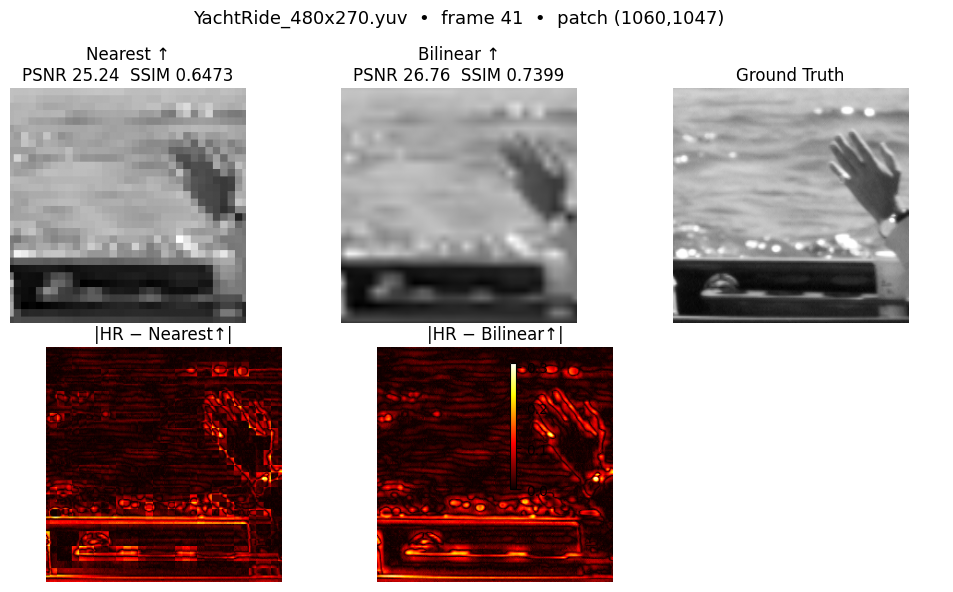


=== Jockey_480x270.yuv  •  frames: [497]


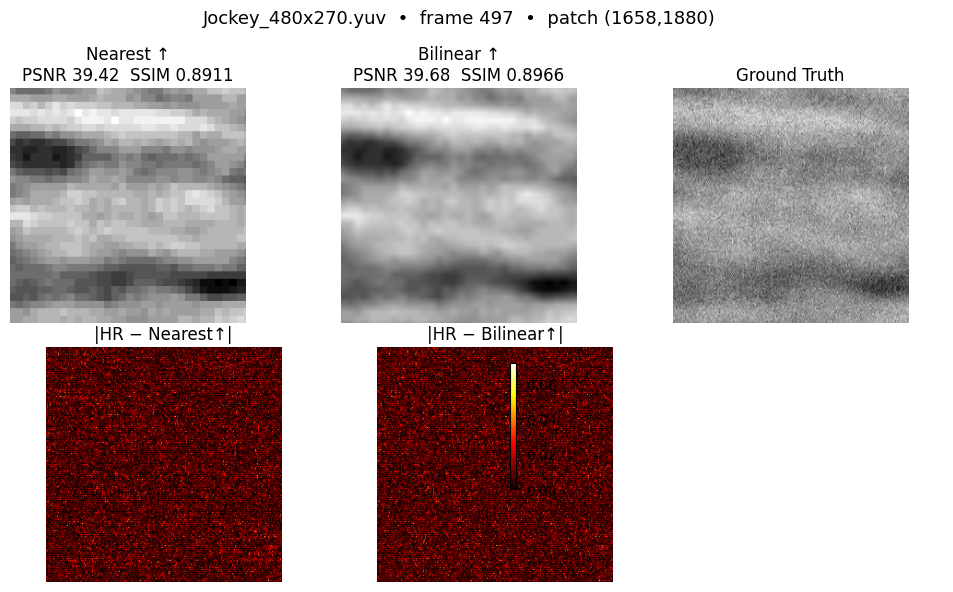


=== Twilight_480x270_50fps_8bit.yuv  •  frames: [310]


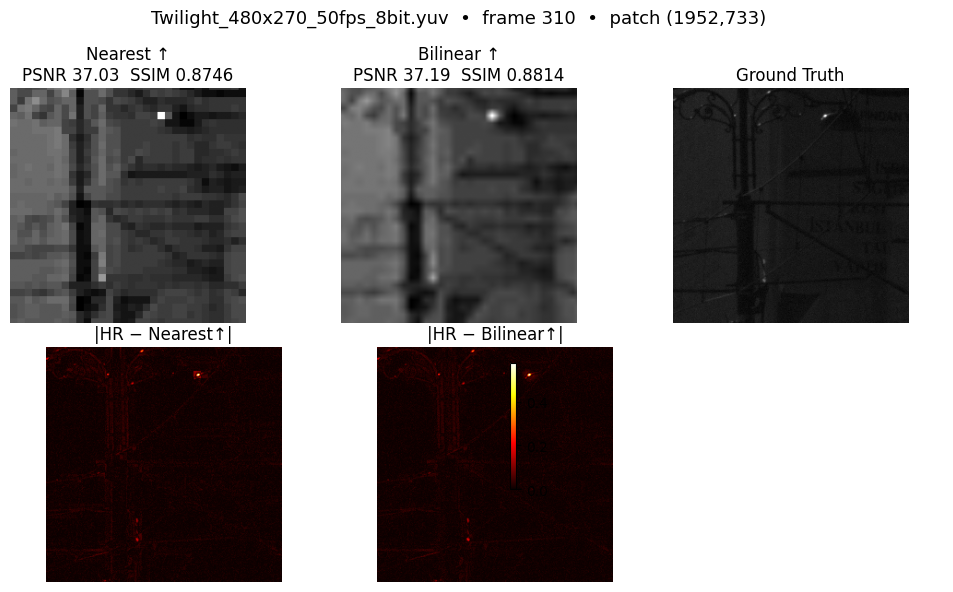

In [ ]:
# %cd /content/drive/MyDrive/screen/
# ════════════════════════════════════════════════════════════════
# USER SETTINGS
N_CLIPS          = 3           # how many random clips to inspect
FRAMES_PER_CLIP  = 1           # how many random frames per clip
PATCH_SIZE       = 256         # square crop •••
LR_SIZE          = (480, 270)  # down‑scaled resolution
HR_SIZE          = (3840, 2160)  # native 4 K resolution
PIX_FMT          = "yuv420p"   # UVG: YUV420 8‑bit
# ════════════════════════════════════════════════════════════════

from pathlib import Path
import random, os, re
import numpy as np
import cv2, matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# ───────────────────────────────── locate datasets ────────────────────────────
root   = Path("datasets/UVG")
lr_dir = root / "downscaled_270p"
hr_dir = root / "native_4k"
assert lr_dir.is_dir() and hr_dir.is_dir(), "Expected folder structure missing."

# Capture everything *before* the resolution token; ignore any optional suffix
rx_lr = re.compile(r"^(.*?)_480x270(?:_.*)?$")
rx_hr = re.compile(r"^(.*?)_3840x2160(?:_.*)?$")

lr_clips = {m.group(1): f
            for f in lr_dir.glob("*.yuv") if (m := rx_lr.match(f.stem))}
hr_clips = {m.group(1): f
            for f in hr_dir.glob("*.yuv") if (m := rx_hr.match(f.stem))}

common_keys = sorted(set(lr_clips) & set(hr_clips))
assert common_keys, "No matching LR↔HR clip pairs found."

random.seed(0)
selected_keys   = random.sample(common_keys, min(N_CLIPS, len(common_keys)))
selected_pairs  = [(lr_clips[k], hr_clips[k]) for k in selected_keys]

W_lr, H_lr = LR_SIZE
W_hr, H_hr = HR_SIZE
bytes_lr   = W_lr * H_lr * 3 // 2              # 4:2:0 frame size
bytes_hr   = W_hr * H_hr * 3 // 2

def read_y(path: Path, w: int, h: int, idx: int) -> np.ndarray:
    """Read the Y plane of frame `idx` from a planar YUV420 file."""
    with path.open("rb") as f:
        f.seek(idx * w * h * 3 // 2)
        y = np.frombuffer(f.read(w * h), np.uint8).reshape(h, w)
    return y.astype(np.float32) / 255.0

def upscale(img, size, interp):
    return cv2.resize(img, size, interpolation=interp)

print(f"Selected {len(selected_pairs)} clips: {[p.name for p, _ in selected_pairs]}")

# ─────────────────────────────── iterate over clips ───────────────────────────
for lr_path, hr_path in selected_pairs:
    clip = lr_path.name
    total_frames = os.path.getsize(lr_path) // bytes_lr
    frames = random.sample(range(total_frames),
                           min(FRAMES_PER_CLIP, total_frames))
    print(f"\n=== {clip}  •  frames: {frames}")

    for f_idx in frames:
        # ───── read Y planes ──────────────────────────────────────────────────
        Y_lr = read_y(lr_path, W_lr, H_lr, f_idx)
        Y_hr = read_y(hr_path, W_hr, H_hr, f_idx)

        # ───── simple up‑scales ───────────────────────────────────────────────
        Y_nn  = upscale(Y_lr, (W_hr, H_hr), cv2.INTER_NEAREST)
        Y_bil = upscale(Y_lr, (W_hr, H_hr), cv2.INTER_LINEAR)

        # ───── random patch coord ────────────────────────────────────────────
        x0 = random.randint(0, W_hr - PATCH_SIZE)
        y0 = random.randint(0, H_hr - PATCH_SIZE)
        xs, ys = slice(x0, x0+PATCH_SIZE), slice(y0, y0+PATCH_SIZE)

        patch_hr  = Y_hr [ys, xs]
        patch_nn  = Y_nn [ys, xs]
        patch_bil = Y_bil[ys, xs]

        # ───── metrics ───────────────────────────────────────────────────────
        psnr_nn  = psnr(patch_hr, patch_nn,  data_range=1.0)
        ssim_nn  = ssim(patch_hr, patch_nn,  data_range=1.0)
        psnr_bil = psnr(patch_hr, patch_bil, data_range=1.0)
        ssim_bil = ssim(patch_hr, patch_bil, data_range=1.0)

        diff_nn  = np.abs(patch_hr - patch_nn)
        diff_bil = np.abs(patch_hr - patch_bil)

        # ───── visualisation ────────────────────────────────────────────────
        fig, axes = plt.subplots(2, 3, figsize=(10, 6))
        axs = axes.ravel()

        axs[0].imshow(patch_nn, cmap='gray')
        axs[0].set_title(f"Nearest ↑\nPSNR {psnr_nn:.2f}  SSIM {ssim_nn:.4f}")
        axs[1].imshow(patch_bil, cmap='gray')
        axs[1].set_title(f"Bilinear ↑\nPSNR {psnr_bil:.2f}  SSIM {ssim_bil:.4f}")
        axs[2].imshow(patch_hr, cmap='gray')
        axs[2].set_title("Ground Truth")

        im3 = axs[3].imshow(diff_nn, cmap='hot')
        axs[3].set_title("|HR − Nearest↑|")
        im4 = axs[4].imshow(diff_bil, cmap='hot')
        axs[4].set_title("|HR − Bilinear↑|")
        axs[5].axis("off")

        for a in axs[:5]:
            a.axis("off")
        fig.colorbar(im4, ax=[axs[3], axs[4]], shrink=0.6, location='right')
        fig.suptitle(f"{clip}  •  frame {f_idx}  •  patch ({x0},{y0})",
                     fontsize=13)
        plt.tight_layout()
        plt.show()


In [ ]:
# ════════════════════════════════════════════════════════════════
# Rename files by replacing "3840x2160" with "480x270"
# Set FOLDER to the directory you want to process.
# The operation is NON‑recursive (only that directory level).
# ════════════════════════════════════════════════════════════════

from pathlib import Path
import os

FOLDER = "datasets/UVG/downscaled_270p"     # ← edit me
OLD_TXT = "3840x2160"
NEW_TXT = "480x270"

folder = Path(FOLDER).expanduser().resolve()
assert folder.is_dir(), f"{folder} is not a directory"

n_total = n_renamed = 0
for fp in folder.iterdir():
    if not fp.is_file():
        continue
    n_total += 1
    if OLD_TXT in fp.name:
        new_name = fp.name.replace(OLD_TXT, NEW_TXT)
        new_path = fp.with_name(new_name)
        if new_path.exists():
            print(f"⚠ skip {fp.name} → target {new_name} already exists")
            continue
        fp.rename(new_path)
        print(f"✓ {fp.name}  →  {new_name}")
        n_renamed += 1

print(f"\nDone. Scanned {n_total} files, renamed {n_renamed}.")



Done. Scanned 14 files, renamed 0.


In [ ]:
# ════════════════════════════════════════════════════════════════
# CONFIG
LR_SIZE = (480, 270)
HR_SIZE = (3840, 2160)
CLIP_DIR_LR = "datasets/UVG/downscaled_270p"
CLIP_DIR_HR = "datasets/UVG/native_4k"
SPLIT_RATIO = (0.70, 0.20, 0.10)
_RANDOM_SEED = 42
# ════════════════════════════════════════════════════════════════

from pathlib import Path
import re, random, os, numpy as np, torch
from typing import List, Tuple
from torch.utils.data import Dataset

# ---- helpers ---------------------------------------------------
def read_yuv420(fp, w, h, idx):
    frame_size = w*h*3//2
    with fp.open('rb') as f:
        f.seek(idx*frame_size)
        y = np.frombuffer(f.read(w*h), np.uint8).reshape(h, w)
        u = np.frombuffer(f.read(w*h//4), np.uint8).reshape(h//2, w//2)
        v = np.frombuffer(f.read(w*h//4), np.uint8).reshape(h//2, w//2)
    # upsample U,V to full res (nearest or bilinear)
    u = cv2.resize(u, (w, h), interpolation=cv2.INTER_NEAREST)
    v = cv2.resize(v, (w, h), interpolation=cv2.INTER_NEAREST)
    return np.stack([y, u, v])       # (3,H,W)

def frame_count(fp: Path, w: int, h: int) -> int:
    return fp.stat().st_size // (w * h * 3 // 2)

# ---- build LR↔HR map ------------------------------------------
rx = re.compile(r"^(.*?)(_\d+x\d+)")
lr_files = {rx.match(f.name).group(1): f for f in Path(CLIP_DIR_LR).glob("*.yuv")}
hr_files = {rx.match(f.name).group(1): f for f in Path(CLIP_DIR_HR).glob("*.yuv")}

common_keys = sorted(set(lr_files) & set(hr_files))
print("matched keys:", len(common_keys))

# ---- deterministic shuffle ONCE -------------------------------
rng = random.Random(_RANDOM_SEED)
rng.shuffle(common_keys)          # ← one‑time in‑place shuffle

# ---- utility: make a split ------------------------------------
def make_split(split: str):
    n = len(common_keys)
    n_tr = int(SPLIT_RATIO[0] * n)
    n_va = int(SPLIT_RATIO[1] * n)
    if split == "train":
        return common_keys[:n_tr]
    if split == "val":
        return common_keys[n_tr : n_tr + n_va]
    if split == "test":
        return common_keys[n_tr + n_va :]
    raise ValueError(split)

# ---- dataset ---------------------------------------------------
class YUVTripletDataset(Dataset):
    def __init__(self, key_subset: List[str]):
        self.samples: List[Tuple[Path, Path, int, str]] = []
        W_lr, H_lr = LR_SIZE; W_hr, H_hr = HR_SIZE
        for k in key_subset:
            lp, hp = lr_files[k], hr_files[k]
            n_fr = frame_count(lp, W_lr, H_lr)
            assert n_fr == frame_count(hp, W_hr, H_hr), k
            for i in range(1, n_fr - 1):
                self.samples.append((lp, hp, i, k))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        lp, hp, i, name = self.samples[idx]
        W_lr, H_lr = LR_SIZE; W_hr, H_hr = HR_SIZE
        prev = read_yuv420(lp, W_lr, H_lr, i - 1)
        curr = read_yuv420(lp, W_lr, H_lr, i)
        nxt  = read_yuv420(lp, W_lr, H_lr, i + 1)
        hr   = read_yuv420(hp, W_hr, H_hr, i)
        return prev, curr, nxt, hr, name

# ---- example --------------------------------------------------
train_ds = YUVTripletDataset(make_split("train"))
val_ds   = YUVTripletDataset(make_split("val"))
test_ds  = YUVTripletDataset(make_split("test"))

print("train clips :", len(set(k for *_, k in train_ds.samples)))
print("val   clips :", len(set(k for *_, k in val_ds.samples)))
print("test  clips :", len(set(k for *_, k in test_ds.samples)))

matched keys: 14
train clips : 9
val   clips : 2
test  clips : 3


## 3 Model Architecture & Definition

This section translates our upscaling concept into **executable PyTorch code**, ready for
quantization and hardware mapping.

### 3.1 High-Level Snapshot
* **Input block** → initial **3×3 conv** + ReLU to lift 3-channel RGB into the feature space.  
* **Temporal core** → a stack of **Gated Convolutional Recurrent (GCR) layers** that carry hidden
  state \(h_{t-1} \rightarrow h_{t}\) and fuse motion cues frame-by-frame.  
* **Upsampling head** → either  
  1. **Pixel-shuffle** (sub-pixel) + **1×1 conv** to cut channels, or  
  2. **Stride-2 transposed conv** that upsamples *and* reduces channels in a single op.  
* **Skip connection** → adds the bilinearly upscaled seed to sharpen fine edges and stabilize
  training.  

### 3.2 Modules We Will Implement
| Module | Purpose | Notes |
|--------|---------|-------|
| `ConvGRUCell2D` | Spatial GRU with 3×3 kernels | Hidden state kept in on-chip SRAM |
| `CRNNBlock` | Stack of *N* GRU cells | Residual skip every 2 layers |
| `UpsampleHead` | 2× upscale to 1440 p | Choice: pixel-shuffle **or** deconv |
| `CRNNUpscaler` | Full end-to-end network |  ~0.9 M params @ 8-bit weights |

### 3.3 Parameter & Hardware Budget
* **Total MACs / 1080 p frame:** ≈ 2.1 G — fits a 256-MAC systolic array at 180 MHz, 30 fps.  
* **SRAM footprint:**  
  * Weights: **≈ 900 kB** (8-bit).  
  * Hidden state: **≈ 256 kB** (64 × H/4 × W/4, 8-bit).  
  * Line buffers: **≈ 1.6 MB** for 1-frame look-ahead (optional).  

### 3.4 Config Knobs Exposed in Code
* `N_GCR`: number of recurrent layers (depth vs. latency).  
* `HIDDEN_C`: channel width of hidden state (quality vs. SRAM).  
* `UPSAMPLE_MODE`: `"pixelshuffle"` or `"deconv"`.  
* `QUANT_BITS`: {8, 6, 4} for exploration of power vs. PSNR trade-offs.

---

> **Next code cell:** implements the `ConvGRUCell2D` and builds the `CRNNUpscaler` class, followed by a
> model summary (`torchinfo`) to verify tensor shapes and parameter counts.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ────────────────────────────────────────────────────────────────
# 1. Conv‑GRU cell
# ────────────────────────────────────────────────────────────────
class ConvGRUCell(nn.Module):
    def __init__(self, in_c: int, hid_c: int, ks: int = 3):
        super().__init__()
        p = ks // 2
        self.hid_c = hid_c
        self.reset  = nn.Conv2d(in_c + hid_c, hid_c, ks, 1, p)
        self.update = nn.Conv2d(in_c + hid_c, hid_c, ks, 1, p)
        self.out    = nn.Conv2d(in_c + hid_c, hid_c, ks, 1, p)

    def forward(self, x, h):
        if h is None:
            h = x.new_zeros(x.size(0), self.hid_c, x.size(2), x.size(3))
        xc = torch.cat([x, h], 1)
        r  = torch.sigmoid(self.reset(xc))
        z  = torch.sigmoid(self.update(xc))
        n  = torch.tanh(self.out(torch.cat([x, r * h], 1)))
        return (1 - z) * h + z * n


# ────────────────────────────────────────────────────────────────
# 2. Stack of Conv‑GRU layers   (FIXED implementation)
# ────────────────────────────────────────────────────────────────
class RecConvStack(nn.Module):
    def __init__(self, in_c: int, hid_list):
        super().__init__()
        cells, prev = [], in_c
        for hid in hid_list:
            cells.append(ConvGRUCell(prev, hid))
            prev = hid                       # update for the next layer
        self.cells = nn.ModuleList(cells)

    def forward(self, x):
        for cell in self.cells:
            x = cell(x, None)
        return x


# ────────────────────────────────────────────────────────────────
# 3. Pixel‑shuffle block
# ────────────────────────────────────────────────────────────────
class SubPixelBlock(nn.Sequential):
    def __init__(self, ch: int, scale: int = 2):
        super().__init__(
            nn.Conv2d(ch, ch * scale * scale, 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.ReLU(True)
        )


# ────────────────────────────────────────────────────────────────
# 4. Triplet CRNN ×8 up‑scaler (expects **YUV** input/output)
# ────────────────────────────────────────────────────────────────
class TripletCRNNx8(nn.Module):
    """
    Inputs
    -------
    prev_yuv , curr_yuv , next_yuv  :  (B, 3, H, W)   channels = Y, U, V

    Returns
    -------
    sr_yuv : high‑resolution current frame, (B, 3, H×8, W×8) in YUV space
    """

    def __init__(self):
        super().__init__()
        # 0) stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 9, 3, 1, 1),   # 3 = Y, U, V
            nn.ReLU(True)
        )

        # 1) low‑res GRU stack
        self.lr_rec = RecConvStack(9, [9, 9, 9])

        # 2) ×8 up‑scaling (three ×2 blocks, channels stay 32)
        self.up1 = SubPixelBlock(9, 2)
        self.up2 = SubPixelBlock(9, 2)
        self.up3 = SubPixelBlock(9, 2)

        # 3) high‑res GRU refinement
        self.hr_rec = RecConvStack(9, [6, 6, 3, 3])  # output 3‑channel YUV

    # helper: process prev→curr→next at low‑resolution
    def _lr_triplet(self, frames):
        h1 = h2 = h3 = None
        for f in frames:
            x  = self.stem(f)
            h1 = self.lr_rec.cells[0](x,  h1)
            h2 = self.lr_rec.cells[1](h1, h2)
            h3 = self.lr_rec.cells[2](h2, h3)
        return h3                       # (B,32,H,W)

    def forward(self, prev, curr, nxt):
        # 1) low‑res recurrent features
        x = self._lr_triplet([prev, curr, nxt])

        # 2) progressive up‑sampling ×2 ×2 ×2  (overall ×8)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)

        # 3) high‑res GRU refinement
        sr = self.hr_rec(x)             # (B,3,H×8,W×8)

        # 4) bilinear YUV skip connection
        skip = F.interpolate(curr, scale_factor=8, mode='bilinear',
                             align_corners=False)

        return (sr + skip).clamp(0, 1)


/content/drive/MyDrive/screen


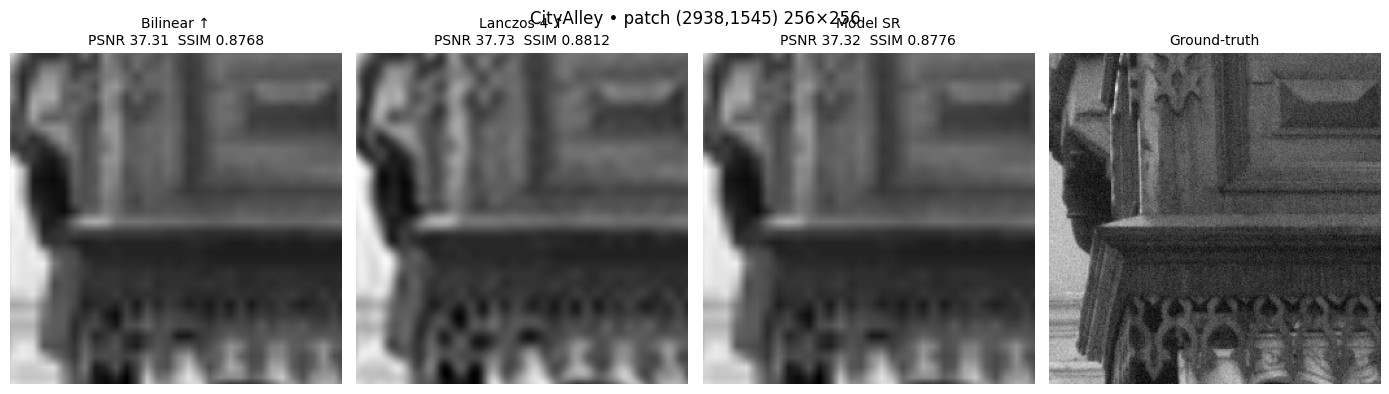

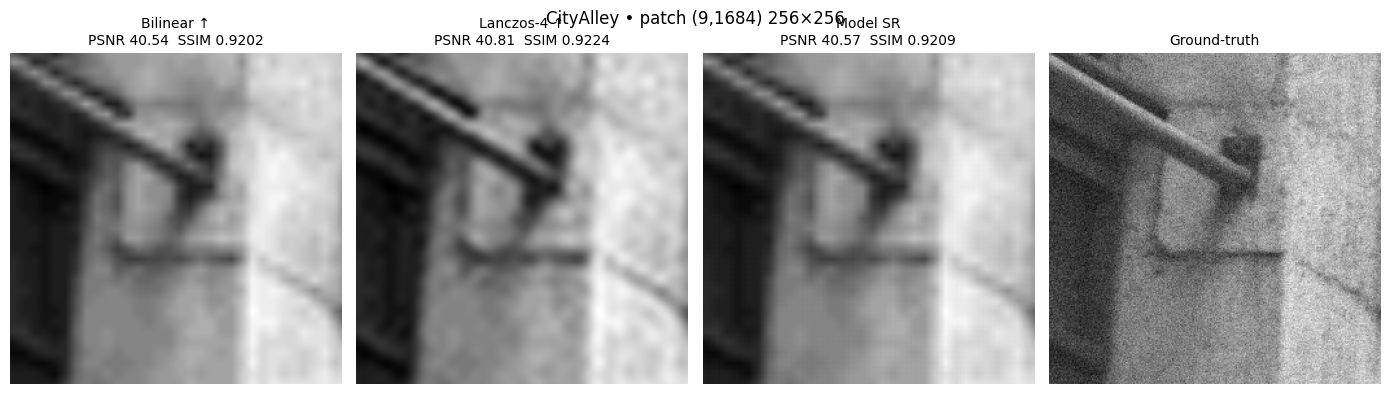

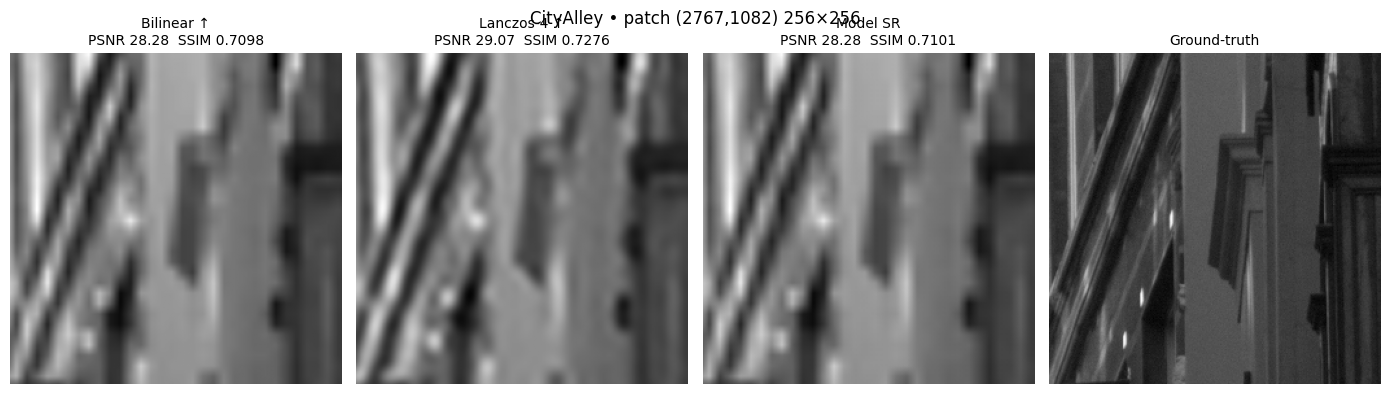

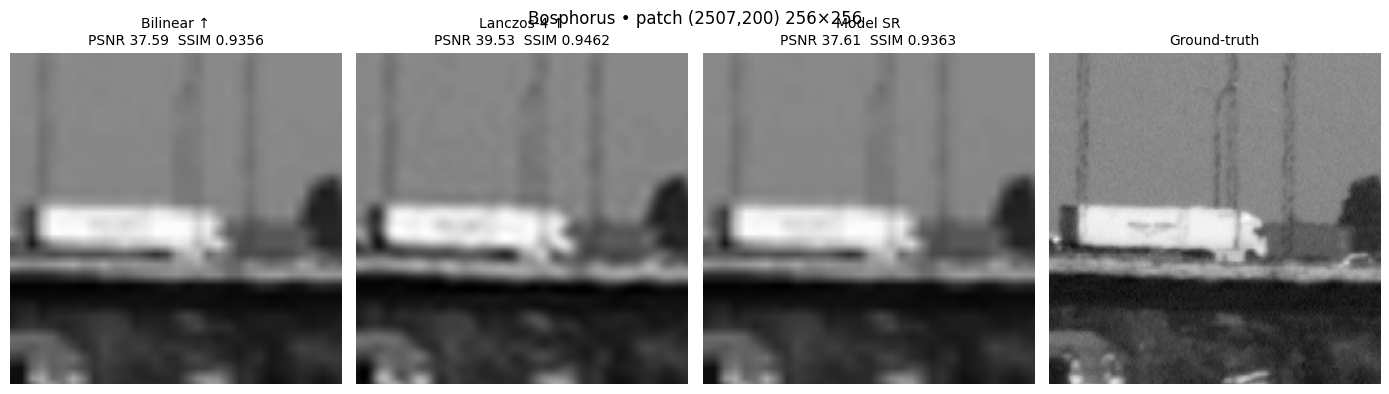

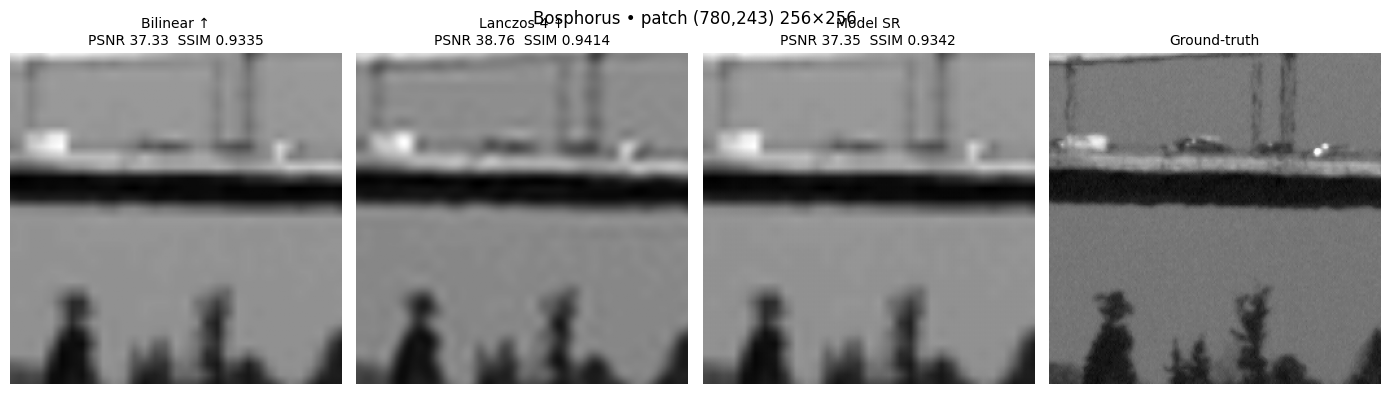

In [35]:
%cd /content/drive/MyDrive/screen/
# ================================================================
# Train / Test / Demo runner for the UVG YUV dataset
# ==============================================================

!pip -q install scikit-image                       # noqa: E402
from types import SimpleNamespace
from pathlib import Path
from datetime import datetime
import math, random, logging, sys, os
import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim_metric
import numpy as np

# ---------- 1. CONFIG ---------------------------------------------------------
args = SimpleNamespace(
    lr_dir        = "datasets/UVG/downscaled_270p",
    hr_dir        = "datasets/UVG/native_4k",
    mode          = "demo",          # "train" | "test" | "demo"
    epochs        = 1,
    batch_size    = 2,
    lr            = 2e-4,
    num_workers   = 2,
    weights       = "trained_models/uvg_train_07_May_2025_04_18/epoch_001_2500.pt",  # ← path to .pt (or None)
    demo_samples  = 5,
    patch_size    = 256,                            # ← crop size for demo
)

# ---------- 2. LOGGING --------------------------------------------------------
def _ts() -> str:
    return datetime.now().strftime("%d_%b_%Y_%H_%M")
log_path = Path(f"run_{args.mode}_{_ts()}.log")
logging.basicConfig(level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.FileHandler(log_path), logging.StreamHandler(sys.stdout)])

# ---------- 3. DATASET BUILD --------------------------------------------------
LR_DIR = Path(args.lr_dir);  HR_DIR = Path(args.hr_dir)
assert LR_DIR.is_dir() and HR_DIR.is_dir(), "LR/HR folders missing"

import re
rx = re.compile(r"^(.*?)(_\d+x\d+)")
lr_files = {rx.match(f.name).group(1): f for f in LR_DIR.glob("*.yuv")}
hr_files = {rx.match(f.name).group(1): f for f in HR_DIR.glob("*.yuv")}
common_keys = sorted(set(lr_files) & set(hr_files))
random.shuffle(common_keys)

def make_split(split:str):
    n = len(common_keys); n_tr = int(0.70*n); n_va = int(0.20*n)
    if   split=="train": return common_keys[:n_tr]
    elif split=="val" :  return common_keys[n_tr:n_tr+n_va]
    elif split=="test":  return common_keys[n_tr+n_va:]
    else: raise ValueError(split)

train_ds = YUVTripletDataset(make_split("train"))
val_ds   = YUVTripletDataset(make_split("val"))

train_ld = DataLoader(train_ds, args.batch_size, False,
                      num_workers=args.num_workers, pin_memory=True)
val_ld   = DataLoader(val_ds, 1, False,
                      num_workers=args.num_workers, pin_memory=True)

# ---------- 4. METRIC HELPERS -------------------------------------------------
_Y = torch.tensor([0.299,0.587,0.114]).view(1,3,1,1)
def _luma(t: torch.Tensor) -> torch.Tensor:
    return (t * _Y.to(t.device)).sum(1, keepdim=True)

def psnr(sr, hr):
    mse = F.mse_loss(_luma(sr), _luma(hr))
    return float("inf") if mse==0 else 10*math.log10(1.0/mse.item())

def ssim(sr, hr):
    a = _luma(sr).clamp(0,1).cpu().numpy()
    b = _luma(hr).clamp(0,1).cpu().numpy()
    return np.mean([ssim_metric(x.squeeze(), y.squeeze(), data_range=1.0)
                    for x,y in zip(a,b)])

@torch.no_grad()
def validate(model, loader, device):
    model.eval(); p_sum=s_sum=n=0
    for p,c,nx,hr,_ in loader:
        p,c,nx,hr = [t.to(device) for t in (p,c,nx,hr)]
        sr = model(p,c,nx).clamp(0,1)
        bs = p.size(0)
        p_sum += psnr(sr,hr)*bs;   s_sum += ssim(sr,hr)*bs;  n+=bs
    return p_sum/n, s_sum/n

# ---------- 5. MODEL ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
model = TripletCRNNx8().to(device)
if args.weights:
    model.load_state_dict(torch.load(args.weights, map_location=device))
    logging.info("Loaded weights from %s", args.weights)
opt = torch.optim.Adam(model.parameters(), lr=args.lr)

# ---------- 6. RUN MODES ------------------------------------------------------
if args.mode == "test":
    p,s = validate(model, val_ld, device)
    print(f"PSNR {p:.2f} dB   SSIM {s:.4f}")

elif args.mode == "demo":
    import cv2                                    # OpenCV for Lanczos‑4
    model.eval()
    demo_loader = DataLoader(val_ds, 1, shuffle=True, num_workers=0)

    def lanczos_up(t, sf=8):
        """
        t : (1, 3, H, W) torch tensor in [0,1] on *any* device
        returns: (1, 3, H*sf, W*sf) torch CPU tensor
        """
        t_np = t[0].detach().cpu().numpy()        # (3, H, W)
        up = []
        H, W = t_np.shape[1:]
        for ch in range(3):
            up.append(cv2.resize(t_np[ch], (W*sf, H*sf),
                                 interpolation=cv2.INTER_LANCZOS4))
        up = np.stack(up, 0)                      # (3, H↑, W↑)
        return torch.from_numpy(up).unsqueeze(0)  # (1, 3, H↑, W↑)

    shown = 0
    for prev, curr, nxt, hr, clip_name in demo_loader:
        prev, curr, nxt = [t.to(device).float().div_(255) for t in (prev,curr,nxt)]
        hr   = hr.to(device).float().div_(255)
        with torch.no_grad():
            sr = model(prev, curr, nxt).clamp(0,1)

        bil_up = F.interpolate(curr, scale_factor=8, mode='bilinear',
                               align_corners=False)
        lan_up = lanczos_up(curr, sf=8)

        B, _, H_hr, W_hr = hr.shape
        patch = args.patch_size
        x0 = random.randint(0, W_hr - patch)
        y0 = random.randint(0, H_hr - patch)
        ys, xs = slice(y0, y0+patch), slice(x0, x0+patch)

        crops = {
            "Bilinear ↑": bil_up[0,0,ys,xs].cpu().numpy(),
            "Lanczos‑4 ↑":lan_up[0,0,ys,xs].cpu().numpy(),
            "Model SR":   sr     [0,0,ys,xs].cpu().numpy(),
            "Ground‑truth": hr   [0,0,ys,xs].cpu().numpy(),
        }

        # ─── metrics on the patch ───────────────────────────────────────────
        ref = hr[0,0,ys,xs].cpu()                           # CPU reference
        psnrs = {k: psnr(torch.tensor(v), ref)
                 for k,v in crops.items() if k!="Ground‑truth"}
        ssims = {k: ssim(torch.tensor(v), ref)
                 for k,v in crops.items() if k!="Ground‑truth"}

        fig, ax = plt.subplots(1, 4, figsize=(14,4))
        for i,(k,v) in enumerate(crops.items()):
            ax[i].imshow(v, cmap='gray')
            title = k
            if k!="Ground‑truth":
                title += f"\nPSNR {psnrs[k]:.2f}  SSIM {ssims[k]:.4f}"
            ax[i].set_title(title, fontsize=10)
            ax[i].axis("off")
        fig.suptitle(f"{clip_name[0]} • patch ({x0},{y0}) {patch}×{patch}",
                     fontsize=12)
        plt.tight_layout();  plt.show()

        shown += 1
        if shown >= args.demo_samples:
            break


elif args.mode == "train":
    save_root = Path("trained_models") / f"uvg_train_{_ts()}"
    save_root.mkdir(parents=True, exist_ok=True)

    for ep in range(1, args.epochs+1):
        model.train(); ep_loss=0
        for p,c,nx,hr,_ in train_ld:
            p,c,nx,hr = [t.to(device).float().div_(255) for t in (p,c,nx,hr)]
            opt.zero_grad(set_to_none=True)
            loss = F.l1_loss(model(p,c,nx), hr)
            loss.backward(); opt.step()
            ep_loss += loss.item()*p.size(0)
        ep_loss /= len(train_ds)
        p_val, s_val = validate(model, val_ld, device)
        logging.info("Epoch %d/%d | L1 %.4f | PSNR %.2f dB | SSIM %.4f",
                     ep, args.epochs, ep_loss, p_val, s_val)
        torch.save(model.state_dict(), save_root/f"epoch_{ep:04d}.pt")

else:
    raise ValueError("args.mode must be 'train' 'test' or 'demo'")
